In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import tempfile
from ast import literal_eval
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf


import fastestimator as fe
from fastestimator.architecture.retinanet import RetinaNet
from fastestimator.op import NumpyOp, TensorOp
from fastestimator.op.numpyop import ImageReader, ResizeImageAndBbox, TypeConverter
from fastestimator.op.tensorop import Loss, ModelOp, Pad, Rescale
from fastestimator.trace import ModelSaver
from fastestimator.dataset import mscoco
from tensorflow.python.keras import regularizers

In [3]:
WIDTH = 512
HEIGHT = 512
num_classes = 12+1

### Load SVHN data set

#### Once this is done we will use COCO data set.

In [4]:
# train_csv, test_csv, path = mscoco.load_data(path='/home/ubuntu/coco', load_object=True, load_caption=False)
path = '/home/ubuntu/coco/MSCOCO2014/'
train_csv = os.path.join(path,'train_new.csv')
val_csv = os.path.join(path, 'val_new.csv')

In [5]:
import pandas as pd
df = pd.read_csv(train_csv)
# df = pd.read_csv(test_csv)
# df.head()

### Create a smaller data set

#### TFRecords generation at high resolution (800x1280) is super slow. I am creating a smaller data set.

### Plot image and bounding box
#### Note: I found that 30.png, 18522.png are not correct.

In [6]:
index = 4000

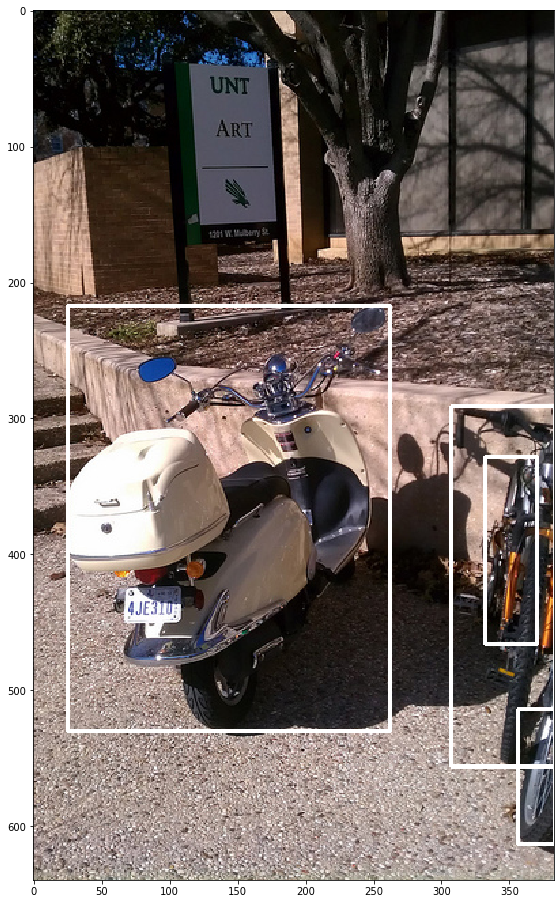

In [7]:
im = cv2.imread(os.path.join(path, df['image'][index]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(figsize=(16,16))
for box_index in range(len(literal_eval(df['label'][index]))):
    x1 = literal_eval(df['x1'][index])[box_index]
    y1 = literal_eval(df['y1'][index])[box_index]
    x2 = literal_eval(df['x2'][index])[box_index]
    y2 = literal_eval(df['y2'][index])[box_index]
    cv2.rectangle(im, (int(x1), int(y1)), (int(x2), int(y2)), (255, 255, 255), 2)
    
plt.imshow(im)
# df.loc[index]

### Create tfrecord writer

In [8]:
from fastestimator.op import NumpyOp
from fastestimator.op.numpyop import ImageReader, Resize
# from fastestimator.util import RecordWriter

In [9]:
class String2List(NumpyOp):
    # this thing converts '[1, 2, 3]' into np.array([1, 2, 3])
    def forward(self, data, state):
        data = map(literal_eval, data)
        return data
    
class GenerateTarget(NumpyOp):
    def __init__(self, inputs=None, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.anchorbox = get_fpn_anchor_box(input_shape=(512, 512, 3))

    def forward(self, data, state):
        obj_label, x1, y1, x2, y2 = data
        cls_gt, x1_gt, y1_gt, x2_gt, y2_gt = get_target(self.anchorbox, obj_label, x1, y1, x2, y2)
        return cls_gt, x1_gt, y1_gt, x2_gt, y2_gt

In [50]:
def get_fpn_anchor_box(input_shape):
    """Returns the anchor boxes of the Feature Pyramid Net.

    Args:
        input_shape (tuple): shape of input image.

    Returns:
        array: numpy array with all anchor boxes.
    """
    assert len(input_shape) == 3
    h, w, _ = input_shape
    assert h % 32 == 0 and w % 32 == 0
    sizes = [32, 64, 128, 256, 512]
    shapes = [(int(h / 8), int(w / 8))]  # P3
    num_pixel = np.prod(shapes)
    for _ in range(4):  # P4 through P7
        shapes.append((int(np.ceil(shapes[-1][0] / 2)), int(np.ceil(shapes[-1][1] / 2))))
        num_pixel += np.prod(shapes[-1])
    anchorbox = np.zeros((9 * num_pixel, 4))
    base_multipliers = [2**(0.0), 2**(1 / 3), 2**(2 / 3)]
    aspect_ratio_multiplier = [(1.0, 1.0), (2.0, 1.0), (1.0, 2.0)]
    anchor_idx = 0
    for shape,size in zip(shapes,sizes):
        p_h, p_w = shape
        base_y = h / p_h
        base_x = w / p_w
        for i in range(p_h):
            center_y = (i + 1 / 2) * base_y
            for j in range(p_w):
                center_x = (j + 1 / 2) * base_x
                for base_multiplier in base_multipliers:
                    for aspect_x, aspect_y in aspect_ratio_multiplier:
                        ratio = aspect_x/aspect_y
                        width_anch = base_multiplier * size
                        height_anch = base_multiplier * size
                        area = width_anch * height_anch
                        width_anch = np.sqrt(area*ratio)
                        height_anch = np.sqrt(area/ratio)
                        x1 = max(center_x - (width_anch) / 2, 0.0)  # x1
                        y1 = max(center_y - (height_anch) / 2, 0.0)  # y1
                        x2 = min(center_x + (width_anch) / 2, float(w))  # x2
                        y2 = min(center_y + (height_anch) / 2, float(h))  # y2
                        anchorbox[anchor_idx, 0] = x1
                        anchorbox[anchor_idx, 1] = y1
                        anchorbox[anchor_idx, 2] = x2 
                        anchorbox[anchor_idx, 3] = y2 
                        anchor_idx += 1
        if p_h == 1 and p_w == 1:  # the next level of 1x1 feature map is still 1x1, therefore ignore
            break
    return np.float32(anchorbox)


def get_iou(boxes1, boxes2):
    """Computes the value of intersection over union (IoU) of two array of boxes.

    Args:
        box1 (array): first boxes in N x 4
        box2 (array): second box in M x 4

    Returns:
        float: IoU value in N x M
    """
    x11, y11, x12, y12 = np.split(boxes1, 4, axis=1)
    x21, y21, x22, y22 = np.split(boxes2, 4, axis=1)
    w1 = x12 - x11
    h1 = y12 - y11
    w2 = x22 - x21
    h2 = y22 - y21
    xmin = np.maximum(x11, np.transpose(x21))
    ymin = np.maximum(y11, np.transpose(y21))
    xmax = np.minimum(x12, np.transpose(x22))
    ymax = np.minimum(y12, np.transpose(y22))
    inter_area = np.maximum((xmax - xmin + 1), 0) * np.maximum((ymax - ymin + 1), 0)
    area1 = (w1 + 1) * (h1 + 1)
    area2 = (w2 + 1) * (h2 + 1)
    iou = inter_area / (area1 + area2.T - inter_area)
    return iou




def get_target(anchorbox, label, x1, y1, x2, y2):
    """Generates classification and localization ground-truths.

    Args:
        anchorbox (array): anchor boxes
        label (array): labels for each anchor box.
        x1 (array): x-coordinate of top left point of the box.
        y1 (array): y-coordinate of top left point of the box.
        x2 (array): x2 coordinate.
        y2 (array): y2 coordinate.

    Returns:
        array: classification groundtruths for each anchor box.
        array: localization groundtruths for each anchor box.
    """
    object_boxes = np.array([x1, y1, x2, y2]).T  # num_obj x 4
    ious = get_iou(object_boxes, anchorbox)  # num_obj x num_anchor
    #now for each object in image, assign the anchor box with highest iou to them
    anchorbox_best_iou_idx = np.argmax(ious, axis=1)
    num_obj = ious.shape[0]
    for row in range(num_obj):
        ious[row, anchorbox_best_iou_idx[row]] = 0.99
    #next, begin the anchor box assignment based on iou
    anchor_to_obj_idx = np.argmax(ious, axis=0)  # num_anchor x 1
    anchor_best_iou = np.max(ious, axis=0)  # num_anchor x 1
    cls_gt = np.int32([label[idx] for idx in anchor_to_obj_idx])  # num_anchor x 1
    cls_gt[np.where(anchor_best_iou <= 0.4)] = -1  #background class
    cls_gt[np.where(np.logical_and(anchor_best_iou > 0.4, anchor_best_iou <= 0.5))] = -2  # ignore these examples
    #finally, get the selected localization coordinates
    anchor_has_object = np.where(cls_gt >= 0)
    box_anchor_obj = anchorbox[anchor_has_object]
    gt_object_idx = anchor_to_obj_idx[anchor_has_object]
    box_gt_obj = object_boxes[gt_object_idx]
    x1_gt, y1_gt, x2_gt, y2_gt = get_loc_offset(box_gt_obj, box_anchor_obj)
    return cls_gt, x1_gt, y1_gt, x2_gt, y2_gt 


def get_loc_offset(box_gt, box_anchor):
    """Computes the offset of a groundtruth box and an anchor box.

    Args:
        box_gt (array): groundtruth box.
        box_anchor (array): anchor box.

    Returns:
        float: offset between x1 coordinate of the two boxes.
        float: offset between y1 coordinate of the two boxes.
        float: offset between x2 coordinate of the two boxes.
        float: offset between y2 coordinate of the two boxes.
    """
    gt_x1, gt_y1, gt_x2, gt_y2 = np.split(box_gt, 4, axis=1)
    ac_x1, ac_y1, ac_x2, ac_y2 = np.split(box_anchor, 4, axis=1)
    dx1 = (gt_x1 - ac_x1) / (ac_x2-ac_x1)
    dy1 = (gt_y1 - ac_y1) / (ac_y2-ac_y1)
    dx2 = (gt_x2 - ac_x2) / (ac_x2-ac_x1)
    dy2 = (gt_y2 - ac_y2) / (ac_y2-ac_y1)
    return dx1, dy1, dx2, dy2



In [51]:
import numpy as np

In [52]:
256+128

384

In [53]:
# !rm -rf /home/ubuntu/coco/MSCOCO2014/retinanet_coco/

In [54]:
batch_samples = pipeline.show_results('train')

In [55]:
batch_samples[0]['x1_gt'][0:8]

<tf.Tensor: id=652677, shape=(8, 1024), dtype=float32, numpy=
array([[ 0.0546875 ,  0.14655524,  0.2500768 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.20236231,  0.07907672,  0.00393718, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.01386461,  0.40625   ,  0.15625   , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.05455073, -0.05242732, -0.12007857, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.04411042, -0.17861427, -0.07438488, ...,  0.        ,
         0.        ,  0.        ],
       [-0.05121546, -0.20870559,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)>

In [56]:
class RetinaLoss(Loss):
    def focal_loss(self, cls_gt_example, cls_pred_example, alpha=0.25, gamma=2.0):
        # cls_gt_example shape: [A], cls_pred_example shape: [A, K]
        num_classes = cls_pred_example.shape[-1]
        # gather the objects and background, discard the rest
        anchor_obj_idx = tf.where(tf.greater_equal(cls_gt_example, 0))
        obj_bg_idx = tf.where(tf.greater_equal(cls_gt_example, -1))
        anchor_obj_count = tf.cast(tf.shape(anchor_obj_idx)[0], tf.float32)
        cls_gt_example = tf.one_hot(cls_gt_example, num_classes)
        cls_gt_example = tf.gather_nd(cls_gt_example, obj_bg_idx)
        cls_pred_example = tf.gather_nd(cls_pred_example, obj_bg_idx)
        cls_gt_example = tf.reshape(cls_gt_example, (-1, 1))
        cls_pred_example = tf.reshape(cls_pred_example, (-1, 1))
        # compute the focal weight on each selected anchor box
        alpha_factor = tf.ones_like(cls_gt_example) * alpha
        alpha_factor = tf.where(tf.equal(cls_gt_example, 1), alpha_factor, 1 - alpha_factor)
        focal_weight = tf.where(tf.equal(cls_gt_example, 1), 1 - cls_pred_example, cls_pred_example)
        focal_weight = alpha_factor * focal_weight**gamma / anchor_obj_count
        cls_loss = tf.losses.BinaryCrossentropy(reduction='sum')(cls_gt_example,
                                                                 cls_pred_example,
                                                                 sample_weight=focal_weight)
        return cls_loss, anchor_obj_idx

    def smooth_l1(self, loc_gt_example, loc_pred_example, anchor_obj_idx):
        # loc_gt is padded x 4, loc_pred is #num_anchor x 4
        loc_pred = tf.gather_nd(loc_pred_example, anchor_obj_idx)  #anchor_obj_count x 4
        anchor_obj_count = tf.shape(loc_pred)[0]
        loc_gt = loc_gt_example[:anchor_obj_count]  #anchor_obj_count x 4
        loc_gt = tf.reshape(loc_gt, (-1, 1))
        loc_pred = tf.reshape(loc_pred, (-1, 1))
        loc_diff = tf.abs(loc_gt - loc_pred)
        smooth_l1_loss = tf.where(tf.less(loc_diff, 1), 0.5 * loc_diff**2, loc_diff - 0.5)
        smooth_l1_loss = tf.reduce_sum(smooth_l1_loss) / tf.cast(anchor_obj_count, tf.float32)
        return smooth_l1_loss

    def forward(self, data, state):
        cls_gt, x1_gt, y1_gt, x2_gt, y2_gt, pred_cls, pred_loc = data
        local_batch_size = state["local_batch_size"]
        focal_loss = []
        l1_loss = []
        total_loss = []
        for idx in range(local_batch_size):
            cls_gt_example = cls_gt[idx]
            x1_gt_example = x1_gt[idx]
            y1_gt_example = y1_gt[idx]
            x2_gt_example = x2_gt[idx]
            y2_gt_example = y2_gt[idx]
            loc_gt_example = tf.transpose(tf.stack([x1_gt_example, y1_gt_example, x2_gt_example, y2_gt_example]))
            cls_pred_example = pred_cls[idx]
            loc_pred_example = pred_loc[idx]
            focal_loss_example, anchor_obj_idx = self.focal_loss(cls_gt_example, cls_pred_example)
            smooth_l1_loss_example = self.smooth_l1(loc_gt_example, loc_pred_example, anchor_obj_idx)
            focal_loss.append(focal_loss_example)
            l1_loss.append(smooth_l1_loss_example)
        focal_loss = tf.stack(focal_loss)
        l1_loss = tf.stack(l1_loss)
        total_loss = focal_loss + l1_loss
        return total_loss, focal_loss, l1_loss

In [65]:
import pdb
from collections import defaultdict
class PredictBox(TensorOp):
    def __init__(self, num_classes, inputs=None, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.anch_box = get_fpn_anchor_box(input_shape=(512, 512, 3))
        self.anch_box = tf.convert_to_tensor(self.anch_box)
        self.num_classes = num_classes
        self.bg_index = num_classes - 1

    def forward(self, data, state):
        cls_pred, loc_pred = data
        batch_size = cls_pred.shape[0]
        loc_base = tf.expand_dims(self.anch_box,0)
        input_width = WIDTH
        input_height = HEIGHT
        top_n = 300
        score_threshold = 0.05
        std = 0.2
        mean = 0
        # convert the residual prediction to absolute prediction in (x1, y1, x2, y2)
        anchor_w_h = tf.tile(loc_base[:,:, 2:], [batch_size, 1, 2]) - tf.tile(loc_base[:, :, :2], [batch_size, 1, 2])
        anchorbox = tf.tile(loc_base[:,:,:],[batch_size,1,1])
        loc_pred_abs = tf.map_fn(lambda x: (x[0] * std + mean) * x[1] + x[2],
                                 elems=(loc_pred, anchor_w_h, anchorbox),
                                 dtype=tf.float32,
                                 back_prop=False)
        x1 = tf.clip_by_value(loc_pred_abs[:, :, 0], 0, input_width)
        y1 = tf.clip_by_value(loc_pred_abs[:, :, 1], 0, input_height)
        x2 = tf.clip_by_value(loc_pred_abs[:, :, 2], 0, input_width)
        y2 = tf.clip_by_value(loc_pred_abs[:, :, 3], 0, input_height)
        loc_pred_abs = tf.stack([x1, y1, x2, y2], axis=2)

        num_batch, num_anchor, _ = loc_pred_abs.shape
        cls_best_score = tf.reduce_max(cls_pred, axis=-1)
        cls_best_class = tf.argmax(cls_pred, axis=-1)

        cls_best_score = tf.where(tf.not_equal(cls_best_class, self.bg_index), cls_best_score, 0)

        # select top n anchor boxes to proceed
        # Padded Nonmax suppression with threshold
        selected_indices_padded = tf.map_fn(
            lambda x: tf.image.non_max_suppression_padded(
                x[0], x[1], top_n, pad_to_max_output_size=True, score_threshold=score_threshold).selected_indices,
            (loc_pred_abs, cls_best_score),
            dtype=tf.int32,
            back_prop=False)
        valid_outputs = tf.map_fn(
            lambda x: tf.image.non_max_suppression_padded(
                x[0], x[1], top_n, pad_to_max_output_size=True, score_threshold=score_threshold).valid_outputs,
            (loc_pred_abs, cls_best_score),
            dtype=tf.int32,
            back_prop=False)
        
        return loc_pred_abs, selected_indices_padded, valid_outputs
    

In [69]:
writer = fe.RecordWriter(
    save_dir=os.path.join(path, "retinanet_coco"),
    train_data=train_csv,
    validation_data=val_csv,
    ops=[
        ImageReader(inputs="image", parent_path=path, outputs="image"),
        String2List(inputs=["x1", "y1", "x2", "y2", "label"],
                    outputs=["x1", "y1", "x2", "y2", "label"]),
        ResizeImageAndBbox(target_size=(512, 512),
                           keep_ratio=True,
                           inputs=["image", "x1", "y1", "x2", "y2"],
                           outputs=["image", "x1", "y1", "x2", "y2", "padding","padimg_targimg_ratio"]),
        GenerateTarget(inputs=("label", "x1", "y1", "x2", "y2"),
                       outputs=("cls_gt", "x1_gt", "y1_gt", "x2_gt", "y2_gt" )),
        TypeConverter(target_type='int32',
                      inputs=["num_obj", "x1", "y1", "x2", "y2", "label", "cls_gt"],
                      outputs=["num_obj", "x1", "y1", "x2", "y2", "label", "cls_gt"]),
        TypeConverter(target_type='float32',
                      inputs=["x1_gt", "y1_gt", "x2_gt", "y2_gt" ],
                      outputs=["x1_gt", "y1_gt", "x2_gt", "y2_gt"])
    ],
    compression="GZIP",
    write_feature=["image", "image_id", "cls_gt", "x1_gt", "y1_gt", "x2_gt", "y2_gt", 
                   "padding", "padimg_targimg_ratio"])
# prepare pipeline
pipeline = fe.Pipeline(
    batch_size=8,
    data=writer,
    ops=[
        Rescale(inputs="image", outputs="image"),
        Pad(padded_shape=[1024],
            inputs=["x1_gt", "y1_gt", "x2_gt", "y2_gt" ],
            outputs=["x1_gt", "y1_gt", "x2_gt", "y2_gt"])
    ])

In [70]:
from fastestimator.trace.adapt.lr_controller import LRController
from fastestimator.trace.metric.coco_mean_avg_precision import MeanAveragePrecision
from fastestimator.trace.metric.mean_avg_precision import Mean_avg_precision

# prepare network
model = fe.build(model_def=lambda: RetinaNet(input_shape=(512, 512, 3), num_classes=num_classes),
                 model_name="retinanet",
                 optimizer=tf.optimizers.Adam(learning_rate=0.00001),
                 loss_name="total_loss")
network = fe.Network(ops=[
    ModelOp(inputs="image", model=model, outputs=["pred_cls", "pred_loc"]),
    PredictBox(num_classes, inputs=["pred_cls","pred_loc"], outputs=("abs_loc","selected_indices_padded", "valid_outputs")),
    RetinaLoss(inputs=("cls_gt", "x1_gt", "y1_gt", "x2_gt", "y2_gt", "pred_cls", "pred_loc"), outputs=["total_loss","focal","smooth"])
])
# prepare estimator
model_dir = os.path.join(path,'bestmodel')
annFile = os.path.join(path, 'annotations/instances_val2014.json')
val_csv = os.path.join(path,'val_new.csv')

# Mean_avg_precision([0,1,2,3,4,5,6,7,8,9,10,11],10,'selected_indices_padded','valid_outputs','image_id','pred_cls', 'abs_loc'),
# MeanAveragePrecision('selected_indices_padded','valid_outputs','image_id','pred_cls', 'abs_loc',
#                          'padimg_targimg_ratio', 'padding', annFile= annFile, val_csv= val_csv)
traces = [ 
    Mean_avg_precision([0,1,2,3,4,5,6,7,8,9,10,11],10,'selected_indices_padded','valid_outputs','image_id',
                       'pred_cls', 'abs_loc',"cls_gt", "x1_gt", "y1_gt", "x2_gt", "y2_gt"),
    LRController(model_name="retinanet", reduce_on_eval=True, reduce_patience=5, reduce_factor=0.5, min_lr=1e-08),
    ModelSaver(model_name="retinanet", save_dir=model_dir, save_best=True)
]
estimator = fe.Estimator(network=network,
                         pipeline=pipeline,
                         epochs=20,
                         traces=traces)

In [71]:
estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator: Reading non-empty directory: /home/ubuntu/coco/MSCOCO2014/retinanet_coco
FastEstimator: Found 5938 examples for train in /home/ubuntu/coco/MSCOCO2014/retinanet_coco/train_summary0.json
FastEstimator: Found 2985 examples for eval in /home/ubuntu/coco/MSCOCO2014/retinanet_coco/eval_summary0.json
FastEstimator-Start: step: 0; total_train_steps: 14840; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 0; total_loss: 1.2124169; focal: 1.1313963; smooth: 0.08102069; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 100; total_loss: 0.8477301; focal

any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
a

any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
a

any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
a

any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
a

any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
a

any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
a

any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
a

any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
a

any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
a

any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
a

any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
a

any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
a

any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
a

any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
a

any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
any iou greater than .5  0
a

KeyboardInterrupt: 

c### Record writer

### Create estimator

In [51]:
6000/8

750.0



## Inference

In [7]:
from tensorflow.keras.models import load_model
model = load_model(os.path.join(path, 'bestmodel','retinanet_best_loss.h5'))

In [8]:
path

'/home/ubuntu/coco'

In [51]:
batch_data = pipeline.show_results(mode='eval',num_steps=5)

FastEstimator: Reading non-empty directory: /home/ubuntu/coco/tfrecords
FastEstimator: Found 5938 examples for train in /home/ubuntu/coco/tfrecords/train_summary0.json
FastEstimator: Found 2985 examples for eval in /home/ubuntu/coco/tfrecords/eval_summary0.json


In [52]:
batch_data[0].keys()

dict_keys(['base_loc', 'image_id', 'target_loc', 'image', 'target_cls'])

In [53]:
batch_data[0]['image'].shape

TensorShape([32, 512, 512, 3])

In [54]:
font = cv2.FONT_HERSHEY_PLAIN

In [23]:
idx = 3

batch_images = batch_data[idx]['image']

batch_images = batch_data[idx]['image']
batch_base_loc = batch_data[idx]['base_loc']
batch_images.shape

cls_pred, loc_pred = model.predict(batch_images)

### Below cell Equivalent to  predict_box 

# equi of __init__
# num_classes = 10 + 1
bg_index = num_classes - 1




loc_base = batch_base_loc
cls_pred = tf.convert_to_tensor(cls_pred)
loc_pred = tf.convert_to_tensor(loc_pred)

input_width = WIDTH
input_height = HEIGHT
top_n = 300
score_threshold = 0.05
std = 0.2
mean = 0


anchor_w_h = tf.tile(loc_base[:, :, 2:], [1, 1, 2]) - tf.tile(loc_base[:, :, :2], [1, 1, 2])
anchorbox = loc_base
loc_pred_abs = tf.map_fn(lambda x: (x[0] * std + mean) * x[1] + x[2],
                             elems=(loc_pred, anchor_w_h, anchorbox),
                             dtype=tf.float32,
                             back_prop=False)
x1 = tf.clip_by_value(loc_pred_abs[:, :, 0], 0, input_width)
y1 = tf.clip_by_value(loc_pred_abs[:, :, 1], 0, input_height)
x2 = tf.clip_by_value(loc_pred_abs[:, :, 2], 0, input_width)
y2 = tf.clip_by_value(loc_pred_abs[:, :, 3], 0, input_height)
loc_pred_abs = tf.stack([x1, y1, x2, y2], axis=2)

num_batch, num_anchor, _ = loc_pred_abs.shape
cls_best_score = tf.reduce_max(cls_pred, axis=-1)
cls_best_class = tf.argmax(cls_pred, axis=-1)

cls_best_score = tf.where(tf.not_equal(cls_best_class, bg_index), cls_best_score, 0)

# select top n anchor boxes to proceed
# Padded Nonmax suppression with threshold
selected_indices_padded = tf.map_fn(
            lambda x: tf.image.non_max_suppression_padded(
                x[0], x[1], top_n, pad_to_max_output_size=True, score_threshold=score_threshold).selected_indices,
            (loc_pred_abs, cls_best_score),
            dtype=tf.int32,
            back_prop=False)

valid_outputs = tf.map_fn(
            lambda x: tf.image.non_max_suppression_padded(
                x[0], x[1], top_n, pad_to_max_output_size=True, score_threshold=score_threshold).valid_outputs,
            (loc_pred_abs, cls_best_score),
            dtype=tf.int32,
            back_prop=False)
# return loc_pred_abs, selected_indices_padded, valid_outputs


cls_pred = cls_pred.numpy()
loc_pred_abs = loc_pred_abs.numpy()


# cls_pred pertains to batch, whereas ele_cls_pred pertains to an element of a batch

batch_idx = np.random.randint(0,16)
elem_selected_indices = selected_indices_padded[batch_idx]
elem_valid_outputs = valid_outputs[batch_idx]
elem_cls_pred = cls_pred[batch_idx]
elem_loc_pred_abs = loc_pred_abs[batch_idx]

indices = elem_selected_indices[:elem_valid_outputs] # indices into anchor boxes
indices = indices.numpy()

predicted_cls = elem_cls_pred[indices] 
predicted_cls = np.argmax(predicted_cls,-1)
predicted_bbox = elem_loc_pred_abs[indices]

predicted_cls

im = batch_images[batch_idx]
im = im.numpy()

fig = plt.figure(figsize=(16,16))
for bbox_index in range(len(predicted_bbox)):
    
    x1,y1,x2,y2 = predicted_bbox[bbox_index]
    cls = predicted_cls[bbox_index]
    cls = index2cat[cls]
    print(cls)
    cv2.rectangle(im, (int(x1), int(y1)), (int(x2), int(y2)), (255, 255, 255), 2)
    cv2.putText(im, cls, (int(x2), int(y2)), font, 2, (255,255,255),2,cv2.LINE_AA, False)
#     cv2.putText(im, cls, (int(x1)+1, int(y1)-14), font, 1, (255,255,0),9, cv2.LINE_AA, False)
    
# plt.imshow(im)

NameError: name 'batch_data' is not defined

In [31]:
index2cat = {
 0: 'bicycle',
 1: 'car',
 2: 'motorcycle',
 3: 'bus',
 4: 'train',
 5: 'truck',
 6: 'boat',
 7: 'bird',
 8: 'cat',
 9: 'dog',
 10: 'horse',
 11: 'sheep'}

{0:2, 1:3, 2:4 ,3:6 ,4:7,5:8,6:9,7:16,8:17,9:18,10:19,11:20 }


In [86]:
path = '/home/ubuntu/fastestimator/apphub/image_detection/retinanet_coco'
fp = os.path.join(path, 'val2014_bbox_results.json')
fp1 = os.path.join(path, 'bbox_result.json')

with open(fp,'r') as f:
    data = json.load(f)

old_tfms =      {0:1, 1:2, 2:3, 3:5, 4:6, 5:7, 6:8, 7:14, 8:15, 9:16, 10:17, 11:18}
category_tfms = {0:2, 1:3, 2:4 ,3:6 ,4:7, 5:8, 6:9, 7:16, 8:17, 9:18, 10:19, 11:20 }
the_tfms =      {1:2, 2:3, 3:4, 5:6, 6:7, 7:8, 8:9, 14:16, 15:17, 16:18, 17:19, 18:20 }

for dict_elem in data:
    val = dict_elem['category_id']
    dict_elem['category_id'] = the_tfms[val]

with open(fp1, 'w') as f:
    json.dump(data, f)

val_new = pd.read_csv('/home/ubuntu/coco/val_new.csv')

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

annFile='/home/ubuntu/coco/annotations/instances_val2014.json'
coco=COCO(annFile)


df = pd.read_csv('/home/ubuntu/coco/val_new.csv')
val_imgIds = df['image_id'].values
val_imgIds = [ int(elem) for elem in val_imgIds]



coco_pred = coco.loadRes('/home/ubuntu/fastestimator/apphub/image_detection/retinanet_coco/bbox_result.json')
# run COCO evaluation
coco_eval = COCOeval(coco, coco_pred, 'bbox')
coco_eval.params.imgIds = val_imgIds
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()




loading annotations into memory...
Done (t=4.49s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.77s).
Accumulating evaluation results...
DONE (t=0.78s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.018
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.019
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

In [27]:
df = {(0,0):'zerozero',(0,1):'zeroone',(0,2):'zerotwo',(2,1):'twoone',(2,2):'twotwo',(1,1):'oneone'}

In [30]:
key_list = df
print(key_list)
key_list = sorted(key_list)
print(key_list)
[df[k] for k in key_list]

{(0, 0): 'zerozero', (0, 1): 'zeroone', (0, 2): 'zerotwo', (2, 1): 'twoone', (2, 2): 'twotwo', (1, 1): 'oneone'}
[(0, 0), (0, 1), (0, 2), (1, 1), (2, 1), (2, 2)]


['zerozero', 'zeroone', 'zerotwo', 'oneone', 'twoone', 'twotwo']